## 🧩 Image Reconstruction

This task focuses on **image denoising and reconstruction** using local low-rank **tensor decomposition** (Tucker or Tensor Train) within segmented image regions.

---

### 🖼️ Problem Setup

You are given a **color image** $ Y \in \mathbb{R}^{I \times J \times 3}$ that is degraded by **Gaussian noise** with:
- Mean = 0  
- Standard deviation = $ \sigma $

---

### 🧱 Step-by-Step Instructions

#### **(a) Superpixel Clustering / Segmentation**

- Segment the noisy image $ Y $ using a superpixel clustering algorithm (e.g., SLIC).
- This produces clusters (segments) of pixels with similar appearance.

#### **(b) Patch Tensor Construction + Low-Rank Approximation**

For **each segment**:

1. **Extract patches**:
   - For each pixel in the segment, extract a centered patch of size $ d \times d \times 3 $.
   - Stack all patches into a tensor:
     $
     X \in \mathbb{R}^{d \times d \times 3 \times K}
     $
     where $K $ is the number of pixels (patches) in the segment.

2. **Denoise using a low-rank tensor model**:
   - Approximate $ X $ using a **Tucker** or **Tensor Train (TT)** decomposition:
     $
     \hat{X} \approx X
     $
   - Subject to a reconstruction error bound:
     $
     \| X - \hat{X} \|_F^2 \leq \epsilon^2 = 3\sigma^2 d^2 K
     $
   - Goal: minimize the **number of parameters** in $ \hat{X} $.

2. **Notes**:
  - For TT: two methods can be used
    - TT decomposition with fixed ranks
    - TT decomposition with error bounded constraints -> it computes the best TT ranks so that the error of approximation is bounded (for each patch)
  - For each method, we have the choice of the shape
    - One may keep the orginal 4-th order format of $X$
    - One can reshape it into a 6-th order tensor format, then compute the TT decomposition. The motivation is to take advantage of TT compression capabilities for high-order tensors, in other words to obtain higher compression
  - Parameters to play with:
    - the value of $\sigma$ - for real life noisy signals, we have to try different values
    - the value of $d$ - this has an impact on the smoothing since higher value for $d$ leads to higher overlapping for the aggregation steps. (cell ""3. Extract patches per superpixel"")
    - activate or not the 6-th order reshaping: set parameter "reshape_for_tt" to False or True (cell"" 4. Denoise each patch GROUP27"")
    - n_segments for superpixel method (cell "2. Superpixel segmentation")

---

#### **(c) Reconstruct the Image**

1. Place denoised patches back into their original image locations.
2. Average overlapping regions.
3. Compute reconstruction quality metrics:
   - **PSNR** (Peak Signal-to-Noise Ratio)
   - **SSIM** (Structural Similarity Index)

---

### 🎯 Goal

Reconstruct a **high-quality, denoised image** by leveraging **local patch redundancy** through **low-rank tensor decompositions** on segments of the image.


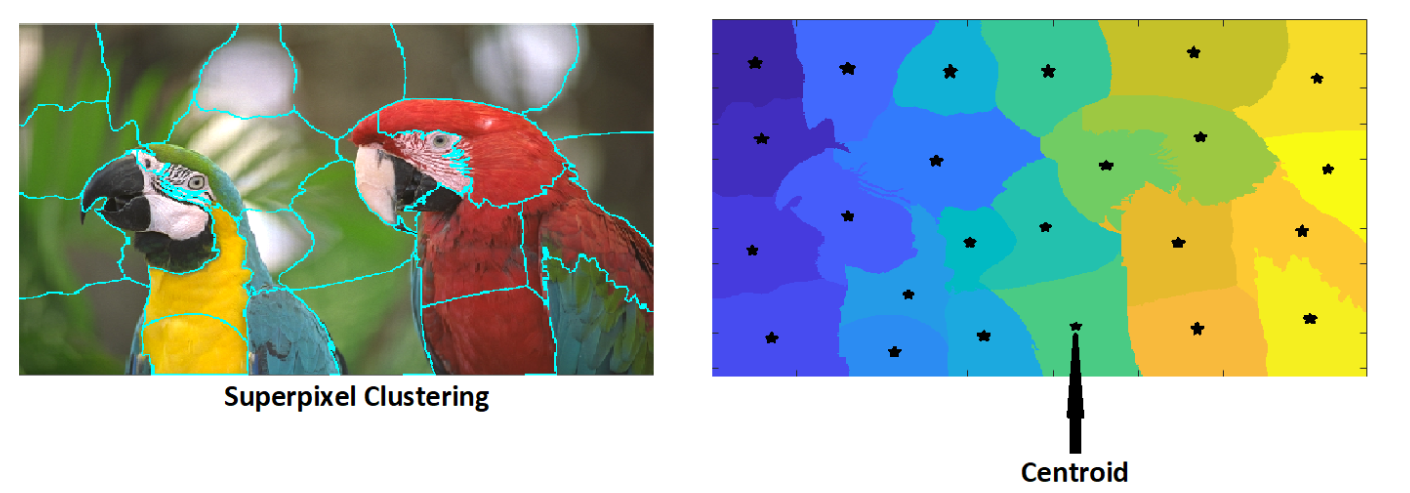

In [1]:
from IPython.display import Image, display

# Display with controlled width/height
display(Image(filename="Datasets/illustration_superpixel.png", width=500, height=300))


Figure 1: Illustration of centroid superpixel sampling

---


We can start now )

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tucker_and_tt_denoise_HOD import (
    load_image, add_gaussian_noise,
    superpixel_segmentation, extract_clustered_patches,
    tucker_decompose_and_denoise, reconstruct_image_from_patches,
    compute_quality_metrics, decompose_and_denoise_patch,tt_num_parameters,
    tt_compression_ratio
)

A very simple test before on a small patch

In [3]:
# Single patch test (4D)
patch = np.random.rand(6, 6, 3, 20)  # (h, w, C)

# Test Tucker
X_hat, (G, U), reshape_for_tt = decompose_and_denoise_patch(patch, method='tucker', sigma=0.1, reshape_for_tt=False)
print(X_hat.shape)  # Should return (6, 6, 3, 20)
print(G.shape, len(U))


17.08517532743315 bound 21.600000000000005
Ranks [6, 6, 3, 16]
(6, 6, 3, 20)
(6, 6, 3, 16) 4


In [4]:
# Test TT adaptative without 6-order reshape
X_hat, tt_tensor, reshape_for_tt = decompose_and_denoise_patch(patch, method='tt_adaptive', sigma=0.1, reshape_for_tt=False, target_order=6)
print(X_hat.shape, len(tt_tensor), reshape_for_tt)


Perform the 1-th Tucker-2 decomposition

Tucker-2 for denoising:

Ranks [16, 6]
0  | (R1,R2) (16, 6) |  #params 2084 | approx 0.02299  | approx.bound 0.03053
1  | (R1,R2) (16, 6) |  #params 2084 | approx 0.02299  | approx.bound 0.03053
Perform the 2-th Tucker-2 decomposition
Approximation Error 21.619563428545007 | Predefined Bound 22.680000000000007
(6, 6, 3, 20) 4 False


In [5]:
# Test TT adaptative with 6-order reshape
X_hat, tt_tensor, reshape_for_tt = decompose_and_denoise_patch(patch, method='tt_adaptive', sigma=0.1, reshape_for_tt=True, target_order=6)
print(X_hat.shape, len(tt_tensor), reshape_for_tt)


Perform the 1-th Tucker-2 decomposition

Tucker-2 for denoising:

Ranks [23, 2]
0  | (R1,R2) (23, 2) |  #params 2143 | approx 0.02812  | approx.bound 0.03053
1  | (R1,R2) (23, 2) |  #params 2143 | approx 0.02812  | approx.bound 0.03053
Perform the 2-th Tucker-2 decomposition

Tucker-2 for denoising:

Ranks [16, 4]
0  | (R1,R2) (16, 4) |  #params 1376 | approx 6.298e-16  | approx.bound 0.002476
1  | (R1,R2) (16, 4) |  #params 1376 | approx 3.149e-16  | approx.bound 0.002476
Perform the 3-th Tucker-2 decomposition
Approximation Error 20.89240353496166 | Predefined Bound 22.680000000000007
(6, 6, 3, 20) 6 True


Now, we can start playing with a true RGB image

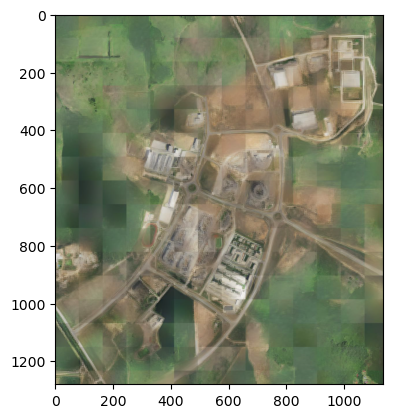

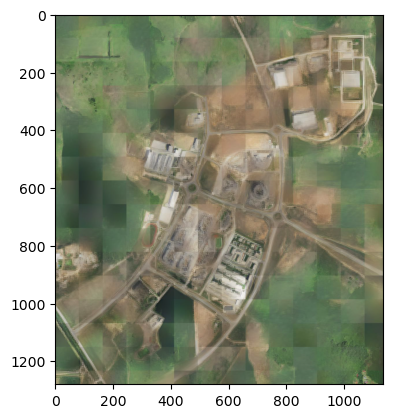

In [ ]:
# 1. Load image + add noise
# image = load_image("Datasets/cat1.jpg")  # Replace with your SR image
# image = load_image("Datasets/baboon.bmp")  # Replace with your SR image
# image = load_image("Datasets/parrot_small.jpg")  # Replace with your SR image
# image = load_image("Datasets/ara.jpeg")
image = load_image("Datasets/SR_Innopolis.jpg")

mean, sigma = 0, 0.001 # add a bit of noise to see....
noisy = add_gaussian_noise(image, mean, sigma)

plt.imshow(image)
plt.show()

plt.imshow(noisy)
plt.show()

In [ ]:
# 2. Superpixel segmentation
# segments = superpixel_segmentation(noisy, n_segments=100, compactness=20) # lower level seg for SR, 2000 for higher level
segments = superpixel_segmentation(noisy, n_segments=2000, compactness=30)

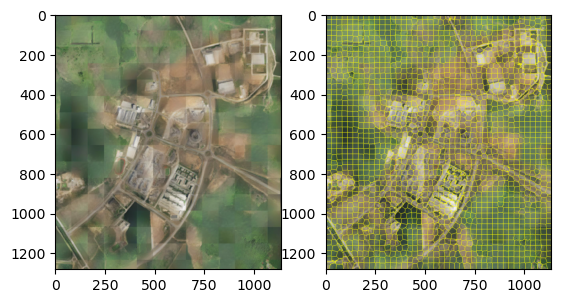

In [8]:
from skimage.segmentation import mark_boundaries
# plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(noisy)
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(noisy, segments))
plt.show()

In [9]:
# 3. Extract patches per superpixel
d = 5
patch_size = d  # Adjust based on tiling artifact size
patches = extract_clustered_patches(noisy, segments, patch_size=patch_size)

In [10]:
len(patches), patches[0][1].shape

(1970, (4, 4, 3, 625))

In [11]:
# 4. Denoise each patch GROUP (order-4 tensor or order-6) - TT
denoised_patches = []
denoised_patches_factors = []
total_params = 0
original_params = 0
chosen_order = 6  # Play carefully with this - for big segment, this can be higher, otherwise use 6 or 4
# sigma = 0.01 # for SR

for segidx, patch_group in patches:
    # patch_group shape: (h, w, C, num_patches)
    print(f'--------------------------------------------------------------------')
    print(f'Decomposing for segment {segidx}')
    # X_hat, G, U = tucker_decompose_and_denoise(patch_group, sigma) # Tucker
    X_hat, tt_tensor, reshape_for_tt = decompose_and_denoise_patch(patch_group, method='tt_adaptive', sigma = sigma, reshape_for_tt=True, target_order=chosen_order)
    denoised_patches.append((segidx, X_hat))
    denoised_patches_factors.append((segidx, tt_tensor))
    total_params = total_params + tt_num_parameters(tt_tensor)
    original_params = original_params + np.prod(patch_group.shape)
    print(f'--------------------------------------------------------------------')

ratio = total_params / original_params
print(f"TT uses {total_params} parameters, compression ratio = {ratio:.4f}")

--------------------------------------------------------------------
Decomposing for segment 1
Perform the 1-th Tucker-2 decomposition

Tucker-2 for denoising:

Ranks [21, 2]
0  | (R1,R2) (21, 2) |  #params 14137 | approx 5.796e-06  | approx.bound 6.714e-06
1  | (R1,R2) (21, 2) |  #params 14137 | approx 5.796e-06  | approx.bound 6.714e-06
Perform the 2-th Tucker-2 decomposition

Tucker-2 for denoising:

Ranks [16, 4]
0  | (R1,R2) (16, 4) |  #params 1280 | approx -1.357e-15  | approx.bound 9.172e-07
1  | (R1,R2) (16, 4) |  #params 1280 | approx -7.754e-16  | approx.bound 9.172e-07
Perform the 3-th Tucker-2 decomposition
Approximation Error 0.027196496473152365 | Predefined Bound 0.0315
--------------------------------------------------------------------
--------------------------------------------------------------------
Decomposing for segment 2
Perform the 1-th Tucker-2 decomposition

Tucker-2 for denoising:

Ranks [25, 2]
0  | (R1,R2) (25, 2) |  #params 26379 | approx 5.474e-06  | ap

In [12]:
np.prod(image.shape)

4362240

In [13]:
reshape_for_tt

True

In [14]:
print(len(denoised_patches))
# print(denoised_patches[0][0])

1970


In [15]:
# 5. Reconstruct image
# Averaging
reconstructed = reconstruct_image_from_patches(
    denoised_patches, segments, noisy.shape, patch_size=patch_size
)
# # Using Marginal Median (High (resistant) to outliers), sharpens edge)
# recon_med = reconstruct_image_from_patches_median(
#     denoised_patches, segments, noisy.shape, patch_size=patch_size
# )  # Resists outlier

In [16]:
reconstructed_image = np.clip(reconstructed, 0, 1)
# reconstructed_image_med = np.clip(recon_med, 0, 1)

(1280, 1136, 3)


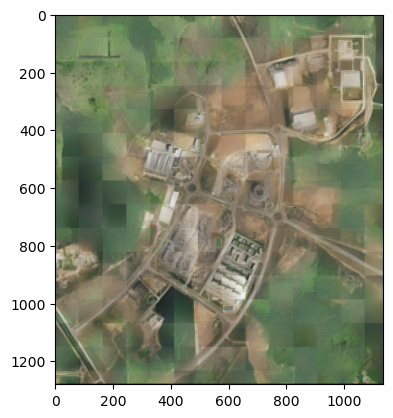

In [17]:
print(reconstructed_image.shape)
plt.imshow(reconstructed_image)

In [18]:
# print(reconstructed_image_med.shape)
# plt.imshow(reconstructed_image_med)

In [19]:
# 6. Compute metrics
psnr, ssim = compute_quality_metrics(
    original=image, 
    reconstructed=reconstructed_image
)
print(f"PSNR: {psnr:.2f}, SSIM: {ssim:.4f}")

# psnr, ssim = compute_quality_metrics(
#     original=image, 
#     reconstructed=reconstructed_image_med
# )
# print(f"PSNR: {psnr:.2f}, SSIM: {ssim:.4f}")

PSNR: 36.95, SSIM: 0.9982
